# Inaugural Project

> **Note the following:** 
> 1. This is an example of how to structure your **inaugural project**.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `inauguralproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [7]:
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt

# Import functions created to solve the project
import inauguralproject_v2 as ip

# Use import lib to reload changes in inauguralproject.py
import importlib
#importlib.reload(ip)
from types import SimpleNamespace # new? explained below

mp = {'phi': 0.3, 'epsilon': 0.5, 'r': 0.03, 'tau_g': 0.012, 'tau_p': 0.004, 'p_bar': 3}

# Question 1

The intiutive way to solve this model remains identical with the method applied when using pen and paper. Hence, this was the most helpful approah to solving this problem:
1. Defined the parameters
2. Define the model (aa stated with modifications such that eq. (2) and (4) are combined
3. Setup maximization problem
4. Solve
5. Display solution

In [8]:
# Define parameters:
par = SimpleNamespace()
par.phi = 0.3
par.eta = 0.5
par.r   = 0.03
par.tg  = 0.012
par.tp  = 0.004
par.ph  = 3.0
par.m   = 0.5
par.eta_reform = 0.8
par.tg_reform  = 0.01
par.tp_reform  = 0.009
par.ph_reform  = 8.0

# Define Model
def utility(c, h, par):
    return c**(1-par.phi)*h**par.phi

#Combined eq. (2) and (4)
def budget(h, par):
    return par.r*h+par.tg*h*par.eta+par.tp*max(h*par.eta-par.ph,0)

def objective(h, par): 
    c=par.m-budget(h, par)
    return -utility(c, h, par)

# Solve
def solver(par):   
    res = optimize.minimize_scalar(objective,args=(par),bounds=None)
    
# Save solution for h and insert in consumption (which is also saved)
    h_star = res.x
    c_star = par.m-budget(h_star, par)
    return c_star, h_star

#Call the solved function to display the final result
solver(par)


(0.35000000225770106, 4.1666666039527485)

In [9]:
# Question 2

In this assignment, I add introduce vectors for both c and h, such that I can plot the optimal combination for different levels of m. 

The result is shown below. 

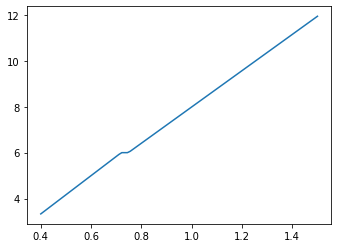

In [10]:
#Creating the figure
fig = plt.figure(figsize=(12,4))

N = 100
m_vec = np.linspace(0.4,1.5,N)
h_vec = np.zeros(N)
c_vec = np.zeros(N)

#Unpack solutions
for i,m in enumerate(m_vec):
    par.m = m
    c,h=solver(par)
    h_vec[i] = h
    c_vec[i] = c

ax = fig.add_subplot(1,2,1)
ax.plot(m_vec,h_vec)



# Question 3

In this assignment I have tried solving the problem as follows:

1. Setting the seed
2. Define the population of N=10.000 consisting of random numbers drawn from the log-normal distribution of cash-on-hand
3. Solved the optimization problem for each cash-on-hand drawn in the population 
4. Calculated the average tax burden pr. household

The sum of all payments is equivalent to the tax revenue. 

In [11]:
N = 10
np.random.seed(1)
ms = np.random.lognormal(-0.40, 0.35, size = N)


# Tax revenues
tax_revenues, hs_star = ip.tax_revenues(mp, ms)

# Print results
print(f'Average housing tax revenue (1000s): {tax_revenues.mean()*1e3:2.3f}')

# Store avg. revenues
avg_tax_revenue_base = tax_revenues.mean()

Average housing tax revenue (1000s): 36.171


# Question 4

Instead of creating a new dictionary at this point, I have addedd the reform-parameters to the SimpleNameSpace in the beginning of the assignment.
Hence, these are denoted with "_reform". However, they are first taken in to use from this assignment. 
As show in the result of the code, the average tax burden pr. household increases with the new reform. 


In [12]:
# New parameters
mp_reform = {'phi': 0.3, 'epsilon': 0.8, 'r': 0.03, 'tau_g': 0.01, 'tau_p': 0.009, 'p_bar': 8}

# Calculate the tax revenues of consumers after the tax reform.
tax_revenues_reform, hs_star_reform = ip.tax_revenues(mp_reform, ms)

# Print results
print(f'Avg. tax after reform: {tax_revenues_reform.mean()*1e3: 2.3f}')
print(f' min tax: {tax_revenues_reform.min() * 1e3: 2.3f}, \n max tax: {tax_revenues_reform.max() * 1e3: 2.3f}')

Avg. tax after reform:  44.597
 min tax:  18.918, 
 max tax:  77.970


# Question 5

In [13]:
# Create a new dictionary
mp_reform_eq = mp_reform.copy()

#Objective function for equalizing tax revenues 
def objective(tau_g, tax_target, ms, mp):
    mp['tau_g'] = tau_g # New versions of tau_g
    new_taxes, hs_stars = ip.tax_revenues(mp, ms) 
    return tax_target - new_taxes.mean()

# Call optimizer.
tax_target = avg_tax_revenue_base
tau_g0 = 0.005 # Initial guess of tau_g
tax_reform_sol = optimize.root(objective, tau_g0, args=(tax_target, ms, mp_reform_eq)) 

# Solve
mp_reform_eq['tau_g'] = tax_reform_sol.x[0]

# Check delta equal to 0, i.e. no difference before or after the reform
taxes_after_reform, hs_stars = ip.tax_revenues(mp_reform_eq, ms)
avg_tax_revenue_reform = taxes_after_reform.mean() 
tax_revenue_delta = tax_target - avg_tax_revenue_reform

# Print 
print('New tau_g to equalize tax revenue after reform: ', mp_reform_eq['tau_g'])
print(f'Average tax revenue before equalizing reform, thousands: {tax_target * 1e3: 2.3f}')
print(f'Average tax revenue after equalizing reform, thousands:  {avg_tax_revenue_reform * 1e3: 2.3f}')
print(f'Difference in average revenues:  {tax_revenue_delta: 2.8f}')

New tau_g to equalize tax revenue after reform:  0.00775821919673834
Average tax revenue before equalizing reform, thousands:  36.171
Average tax revenue after equalizing reform, thousands:   36.171
Difference in average revenues:   0.00000000


# Conclusion

The model framework can be setup in code such that i simulated scenario allows for a clear solution to each problem that easily demonstrates the dynamics of the model. 
It is shown that the reforming the tax without concern for distortion in the average tax burden for each household yields a sub-optimal solution. However, the problem can be solved by ensuring no distortion in the tax burden by offsetting the parameter increases using T^g such that there is no difference in the tax revenues after the reform. 